In [158]:
import pyupbit
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings(action='ignore')

## 터틀 알고리즘
- 설명 : 시세가 4주 동안의 최고치를 경신하면 롱 포지션 진입, 반대로 시세가 2주 동안의 최저치를 경신하면 숏 포지션 진입
  

In [192]:
df = pyupbit.get_ohlcv(ticker="KRW-ETH", interval="1d", to="2021-10-17", count=1460)

In [193]:
def get_high_price(df, idx): 
    test_price = df.iloc[idx].high
    df_30 = df[idx - 30: idx].high
    price_ordering = []
    
    for price in df_30:
        if price > test_price:
            return False
        
        price_ordering.append(price)
        
    return max(price_ordering)


def get_low_price(df, idx):
    test_price = df.iloc[idx].low
    df_15 = df[idx - 15: idx].low
    price_ordering = []
    
    for price in df_15:
        if price < test_price:
            return False
        
        price_ordering.append(price)
    
    return min(price_ordering)

def visualize_return_rate(df):
    plt.figure(figsize = (20, 8))
    plt.plot(df.index, df['hpr']*100, color = 'r')
    plt.plot(df.index, df['n_hpr']*100, color = 'k', linestyle = '--')
    plt.legend(loc='best')
    plt.title(f"mdd: {round(df['mdd'].max(), 2)}\
                return_rate: {round(df['hpr'].iloc[-1] * 100 - 100, 2)}%")
    plt.ylabel("rate of return")
    plt.grid(True)
    plt.show()


position = 0 
position_list = []
postion_price_list = []

for idx, data in enumerate(df[30:].itertuples(), 30):
    
    if position == 0:
        if result := get_high_price(df, idx):
            position = 1
            position_list.append(position)
            postion_price_list.append(result)
            
        elif result := get_low_price(df, idx):
            position = 2
            position_list.append(position)
            postion_price_list.append(result)
        
        else:
            position_list.append(position)
            postion_price_list.append(None)
        
    elif position == 1:
        if result := get_low_price(df, idx):
            position = 2
            position_list.append(position)
            postion_price_list.append(result)
        else:
            position_list.append(position)
            postion_price_list.append(None)
    
    elif position == 2:
        if result := get_high_price(df, idx):
            position = 1
            position_list.append(position)
            postion_price_list.append(result)
        else:
            position_list.append(position)
            postion_price_list.append(None)

            
df = df[30:].copy()
df['position'] = position_list
df['position_price'] =postion_price_list

def set_price(x):
    result = None
    
    if x.position == 1:
        if x.position_price:
            result = x.close / x.position_price  - 0.001 
        else:
            result = x.close / x.open  - 0.001
            
    elif x.position == 2:
        if x.position_price:
            result = x.position_price / x.close  - 0.001
        else:
            result = x.open / x.close  - 0.001
        
    return result

df = df.replace(np.nan, 0, regex=True)

daily_rr = list(map(lambda x: set_price(x), df.itertuples()))


df['daily_rr'] = daily_rr
df = df.dropna()
df['hpr'] = df['daily_rr'].cumprod()
df['nr'] = df['close'] / df['open'] # normal rate
df['n_hpr'] = df['nr'].cumprod() 
df['mdd'] = (df['hpr'].cummax() - df['hpr']) / df['hpr'].cummax() * 100 
df['n_mdd'] = (df['n_hpr'].cummax() - df['n_hpr']) / df['n_hpr'].cummax() * 100

No handles with labels found to put in legend.


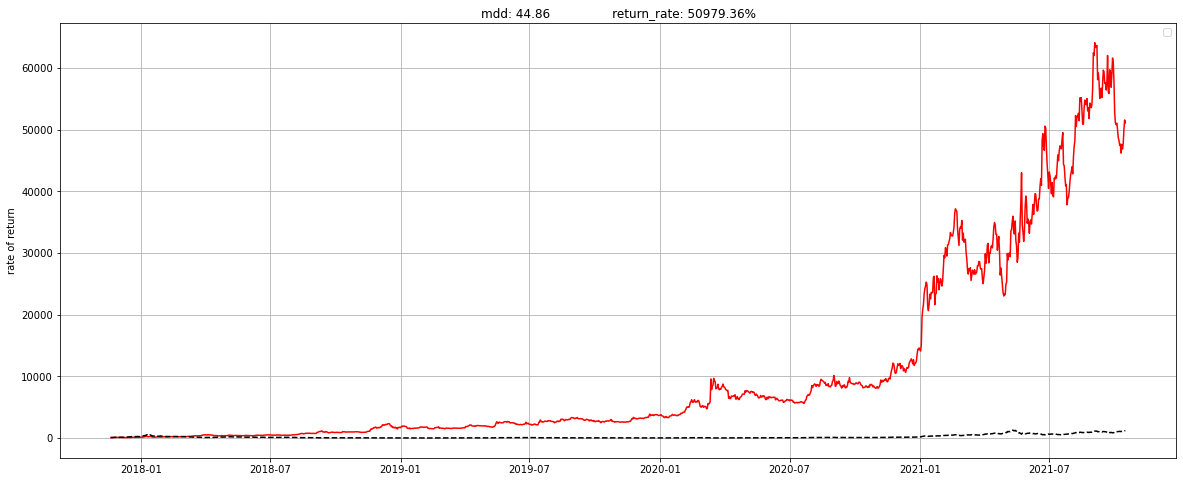

In [194]:
visualize_return_rate(df)

In [195]:
df

,open,high,low,close,volume,value,position,position_price,daily_rr,hpr,nr,n_hpr,mdd,n_mdd
2017-11-19 09:00:00,383650.0,414950.0,378450.0,388600.0,63712.227582,2.505265e+10,1,407000.0,0.953791,0.953791,1.012902,1.012902,0.000000,0.000000
2017-11-20 09:00:00,388600.0,408000.0,384400.0,398650.0,78974.754030,3.111683e+10,1,0.0,1.024862,0.977504,1.025862,1.039098,0.000000,0.000000
2017-11-21 09:00:00,398650.0,408500.0,380050.0,397600.0,80724.414544,3.223401e+10,1,0.0,0.996366,0.973952,0.997366,1.036361,0.363389,0.263389
2017-11-22 09:00:00,397600.0,421050.0,396000.0,419200.0,98159.000776,3.966929e+10,1,0.0,1.053326,1.025889,1.054326,1.092663,0.000000,0.000000
2017-11-23 09:00:00,419200.0,470000.0,412050.0,452450.0,127814.959028,5.597008e+10,1,0.0,1.078318,1.106234,1.079318,1.179330,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-12 09:00:00,4374000.0,4378000.0,4232000.0,4311000.0,55160.978079,2.370470e+11,1,0.0,0.984597,468.523277,0.985597,10.834544,26.878201,16.694923
2021-10-13 09:00:00,4311000.0,4403000.0,4204000.0,4394000.0,51655.331949,2.221580e+11,1,0.0,1.018253,477.075267,1.019253,11.043143,25.543503,15.091044
2021-10-14 09:00:00,4389000.0,4649000.0,4370000.0,4609000.0,79166.711127,3.580677e+11,1,0.0,1.049125,500.511739,1.050125,11.596684,21.885804,10.834956
2021-10-15 09:00:00,4609000.0,4770000.0,4555000.0,4752000.0,115787.571134,5.396099e+11,1,0.0,1.030026,515.540231,1.031026,11.956485,19.540328,8.068499
